In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
# import xgboost as xgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import fastai

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import warnings
warnings.filterwarnings('ignore')

/home/aman/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aman/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
%%time
train_df = load_df()
test_df = load_df("data/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 58s, sys: 5.66 s, total: 4min 4s
Wall time: 3min 59s


In [6]:
train = train_df
test = test_df

In [7]:
train['date'] = train.date.apply(str)

In [8]:
train['date'] = train['date'].str[:4] + '-' + train['date'].str[4:6] + '-' + train['date'].str[6:8]

In [9]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)

In [10]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [11]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


In [12]:
# Columns with constant values
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1]
cols_to_drop = const_cols + ['sessionId'] 

train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test = test.drop(cols_to_drop, axis=1)

In [13]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       '

In [14]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
            'Year', 'Month', 'Week', 'Day', 'Dayofweek',
            'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
            'Is_quarter_start', 'Is_year_end', 'Is_year_start'
           ]

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 
            "visitStartTime", 'totals.bounces',  'totals.newVisits']

In [15]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
Year
Month
Week
Day
Dayofweek
Dayofyear
Is_month_end
Is_month_start
Is_quarter_end
Is_quarter_start
Is_year_end
Is_year_start


In [17]:
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [20]:
test[:-10]

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,4,1970-01-01 00:00:00.020171016,6167871330617112363,1508151024,2.0,1.508151e+09,35,0,False,7,1,3,176,0,24691,0,16,NaN,4.0,NaN,4.0,62,3,59008,1,11,3,4,0,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
1,4,1970-01-01 00:00:00.020171016,0643697640977915618,1508175522,1.0,1.508176e+09,35,0,False,20,948,4,185,0,30734,23,19,NaN,5.0,1.0,5.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
2,4,1970-01-01 00:00:00.020171016,6059383810968229466,1508143220,1.0,1.508143e+09,35,0,False,7,955,4,69,122,32535,482,22,NaN,7.0,1.0,7.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
3,4,1970-01-01 00:00:00.020171016,2376720078563423631,1508193530,1.0,1.508194e+09,72,1,True,23,540,2,218,100,0,73,12,NaN,8.0,1.0,4.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
4,4,1970-01-01 00:00:00.020171016,2314544520795440038,1508217442,1.0,1.508217e+09,72,0,False,7,751,2,218,100,0,73,12,NaN,9.0,1.0,4.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
5,4,1970-01-01 00:00:00.020171016,4133039884103392367,1508186358,1.0,1.508186e+09,35,0,False,6,955,2,218,122,0,482,12,NaN,11.0,1.0,5.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
6,4,1970-01-01 00:00:00.020171016,4320478850207397557,1508203650,1.0,1.508204e+09,35,0,False,7,955,2,218,122,14768,482,12,NaN,37.0,1.0,15.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
7,4,1970-01-01 00:00:00.020171016,5876438247590157131,1508184397,1.0,1.508184e+09,35,0,False,20,955,2,218,122,21244,482,12,NaN,52.0,1.0,22.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
8,4,1970-01-01 00:00:00.020171016,0514591268737702944,1508189652,6.0,1.508190e+09,35,0,False,7,452,4,162,0,29508,225,19,NaN,5.0,NaN,5.0,62,3,59008,1,11,3,4,0,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
9,4,1970-01-01 00:00:00.020171016,6430567031531677212,1508175502,1.0,1.508176e+09,35,0,False,20,948,4,185,0,30734,23,19,NaN,6.0,1.0,6.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0


In [21]:
# for v in cat_cols: train[v] = train[v].astype('category').cat.as_ordered()

In [22]:
for v in num_cols:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0).astype('float32')

In [31]:
train.to_csv('data/cleaned_train.csv', header=True, index=None, encoding='utf-8')
test.to_csv('data/cleaned_test.csv', header=True, index=None, encoding='utf-8')

In [30]:
test

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,4,1970-01-01 00:00:00.020171016,6167871330617112363,1508151024,2.0,1.508151e+09,35,0,False,7,1,3,176,0,24691,0,16,0.0,4.0,0.0,4.0,62,3,59008,1,11,3,4,0,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
1,4,1970-01-01 00:00:00.020171016,0643697640977915618,1508175522,1.0,1.508175e+09,35,0,False,20,948,4,185,0,30734,23,19,0.0,5.0,1.0,5.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
2,4,1970-01-01 00:00:00.020171016,6059383810968229466,1508143220,1.0,1.508143e+09,35,0,False,7,955,4,69,122,32535,482,22,0.0,7.0,1.0,7.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
3,4,1970-01-01 00:00:00.020171016,2376720078563423631,1508193530,1.0,1.508194e+09,72,1,True,23,540,2,218,100,0,73,12,0.0,8.0,1.0,4.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
4,4,1970-01-01 00:00:00.020171016,2314544520795440038,1508217442,1.0,1.508217e+09,72,0,False,7,751,2,218,100,0,73,12,0.0,9.0,1.0,4.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
5,4,1970-01-01 00:00:00.020171016,4133039884103392367,1508186358,1.0,1.508186e+09,35,0,False,6,955,2,218,122,0,482,12,0.0,11.0,1.0,5.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
6,4,1970-01-01 00:00:00.020171016,4320478850207397557,1508203650,1.0,1.508204e+09,35,0,False,7,955,2,218,122,14768,482,12,0.0,37.0,1.0,15.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
7,4,1970-01-01 00:00:00.020171016,5876438247590157131,1508184397,1.0,1.508184e+09,35,0,False,20,955,2,218,122,21244,482,12,0.0,52.0,1.0,22.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
8,4,1970-01-01 00:00:00.020171016,0514591268737702944,1508189652,6.0,1.508190e+09,35,0,False,7,452,4,162,0,29508,225,19,0.0,5.0,0.0,5.0,62,3,59008,1,11,3,4,0,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0
9,4,1970-01-01 00:00:00.020171016,6430567031531677212,1508175502,1.0,1.508175e+09,35,0,False,20,948,4,185,0,30734,23,19,0.0,6.0,1.0,6.0,62,3,59008,1,11,3,4,1,11,5,3196,208,0,0,0,0,3,0,0,1,0,1,0,1,0


In [18]:
apply_cats(test, train)

In [20]:
train = train[cat_cols + num_cols + ['totals.transactionRevenue']]
test = test[cat_cols + num_cols]

In [21]:
test['totals.transactionRevenue'] = 0.0

In [22]:
df, y, nas, mapper = proc_df(train, 'totals.transactionRevenue', do_scale=True)
yl = np.log(y)

In [23]:
yl[yl<0] = 0

In [24]:
df_test, _, nas, mapper = proc_df(test, 'totals.transactionRevenue', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [74]:
samp_size = len(df)
train_ratio = 0.9
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [75]:
def score_metric(y_pred, targ):
    p = np.expm1(y_pred)
    t = np.expm1(targ)
    p[p < 0] = 0
    return np.sqrt(metrics.mean_squared_error(np.log1p(t), np.log1p(p)))

In [76]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [77]:
y_range

(0, 28.637248992919922)

In [78]:
PATH='data/' # UNNECESSARY
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_cols, bs=128,
                                       test_df=df_test)

In [79]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_cols]

In [80]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [81]:
df_test.shape

(804684, 41)

In [82]:
df.shape

(903653, 41)

In [85]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 5]),
                           ('trainable', True),
                           ('nb_params', tensor(45))])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(1540))])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', tensor(8))])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 11]),
                           ('trainable', True),
                           ('nb_params', tensor(231))])),
             ('Embedding-5',
              O

In [86]:
lr = 1e-5
m.lr_find()

epoch      trn_loss   val_loss                                 
    0      3.924494   3.906993  



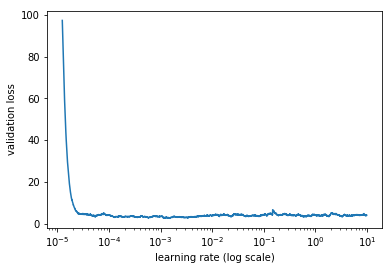

In [87]:
m.sched.plot(100)

In [ ]:
lr = 1e-4
m.fit(lr, 3, metrics=[score_metric])

In [ ]:
m.fit(lr, 2, metrics=[score_metric], cycle_len=4)

In [88]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

In [89]:
m.fit(lr, 1, metrics=[score_metric])

epoch      trn_loss   val_loss   score_metric                  
    0      2.858336   2.671869   0.757988  



[2.6718691265596917, 0.7579881212826262]

In [ ]:
m.fit(lr, 3, metrics=[score_metric])

In [102]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                    0.04, 1, [500], [0.001], y_range=y_range)
lr = 1e-4

In [103]:
m.fit(lr, 3, metrics=[score_metric])

epoch      trn_loss   val_loss   score_metric                  
    0      3.025377   2.739079   0.809881  
    1      2.871442   2.685532   0.766757                      
    2      2.36367    2.690527   0.762681                      



[2.6905269616670036, 0.7626807189557574]

In [104]:
y=m.predict()

In [105]:
max(md.val_y)

array([22.88404], dtype=float32)

In [106]:
score_metric(y, md.val_y)

1.6402826

In [107]:
pred_test=m.predict(True)

In [101]:
sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_nn.csv", index=False)

In [37]:
m.save('val0')